# CS4287 Assignnment 01


Kevin Collins: 21344256
Olan Healy: 21318204

Does code execute without an error? Yes


Note: You will need to have the csv file in same directory to run

link to existing implementation: https://learn.ul.ie/d2l/le/lessons/45660/topics/815708


This was the sample submission, mainly used for structure and ideas

If you are running locally i.e through something like vscode, you will need to have all necessacary libraires installed

In [5]:
# Importing necessacary libaries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout
import time

In [6]:
# Print first 5 rows of the raw dataset
dataset_path = 'employee_mental_fatigue.csv'
df = pd.read_csv(dataset_path)

display(df.head())



,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


<ipython-input-7-8ce4edf0f880>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='pastel')


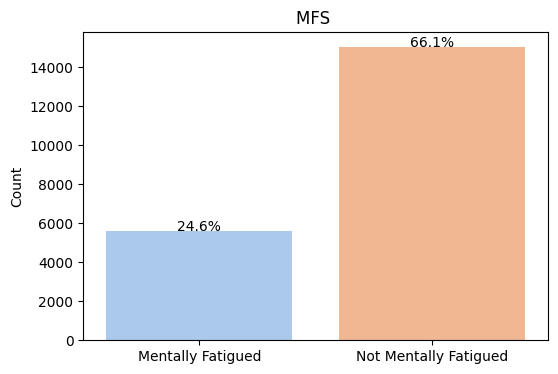

{'Mentally Fatigued': 5593, 'Not Mentally Fatigued': 15040}


In [7]:
# We are going to look at the Mental Fatigue score as our target variable so here we are just looking at the % of dataset where the score
# of mental fatigue is >= 7 is someone who is 'Mentally Fatigued'. We are saying that someone with a mental fatigue score of <7 is not mentally fatigued

# Count the number of scores greater than 7 and less than or equal to 7
mentally_fatigued = (df['Mental Fatigue Score'] >= 7).sum()
not_mentally_fatigued = (df['Mental Fatigue Score'] < 7).sum()

# get list for plotting, MFS = Mental fatigue score
labels = ['Mentally Fatigued', 'Not Mentally Fatigued']
counts = [mentally_fatigued, not_mentally_fatigued]

# Calculate percentages
total_count = len(df)
percentages = [(count / total_count) * 100 for count in counts]

# plot counts
plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=counts, palette='pastel')

# Adding labels and title
plt.ylabel('Count')
plt.title('MFS ')

# Adding percentages underneath the bars
for index, (count, percentage) in enumerate(zip(counts, percentages)):
    plt.text(index, count + 5, f'{percentage:.1f}%', ha='center')

plt.show()

# Displaying the exact counts
fatigue_counts = {'Mentally Fatigued': mentally_fatigued, 'Not Mentally Fatigued': not_mentally_fatigued}
print(fatigue_counts)

<ipython-input-8-8a3b589753d7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Gender', palette='pastel')


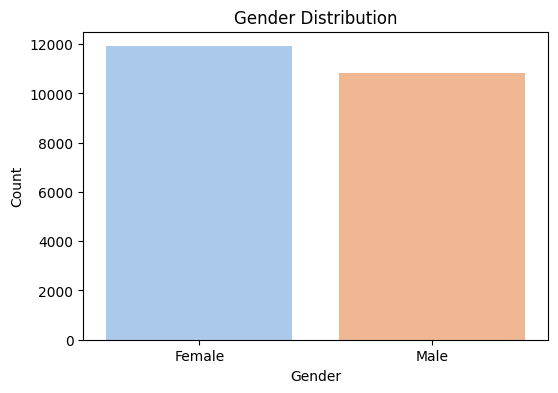

In [8]:
# This is the distribution of the genders in the dataset
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Gender', palette='pastel')
plt.title('Gender Distribution')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()

The network structure and other hyperparameters (1 marks).


In [9]:
# Class for preprocessing our dataset
class Dataset:
    def __init__(self):
        self.raw = pd.read_csv('employee_mental_fatigue.csv')

        # Select columns we chose for feature extraction (excluding Mental Fatigue Score)
        self.cols = ['Gender', 'Company Type', 'WFH Setup Available', 'Designation', 'Resource Allocation', 'Burn Rate']

        # Convert categorical values to binary:
        # Gender Male: 1 , Female: 0
        # Company Type: Product: 1, Service: 0
        # WFH: Yes: 1, No: 0
        self.raw['Gender'] = self.raw['Gender'].replace({'Male': 1, 'Female': 0})
        self.raw['Company Type'] = self.raw['Company Type'].replace({'Product': 1, 'Service': 0})
        self.raw['WFH Setup Available'] = self.raw['WFH Setup Available'].replace({'Yes': 1, 'No': 0})

        # shows rows with empty values
        print(self.raw.isnull().sum())
        # If empty drop as there are over 2000 empty rows for Mental Fatigue Score, removing noise as doesnt offer any value to training
        self.raw = self.raw.dropna()
        print(self.raw.isnull().sum())

        # Select relevant columns for X
        self.X = self.raw[self.cols]

        # Create y, our target variable as Mental Fatigue Score if value is > 7
        self.y = (self.raw['Mental Fatigue Score'] > 7).astype(int)


        self.normalize()

    # Function for printing
    def print(self):
        print(self.X.head())
        print(self.y.head())

    # function for normalising the dataset
    def normalize(self):

        #MinimaxScaler used
        scaler = MinMaxScaler()
        #only scale on the numeric as cathegorical data is converted to binary already
        numeric_cols = ['Designation', 'Resource Allocation', 'Burn Rate']
        self.X[numeric_cols] = scaler.fit_transform(self.X[numeric_cols])

    # Function for correlation heatmap when dataset has been preprocessed
    def plot_correlation_heatmap(self):
        # Combine X and y for correlation analysis
        data_for_corr = pd.concat([self.X, self.y], axis=1)

        # Compute the correlation matrix
        corr_matrix = data_for_corr.corr()

        # Create a heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title('Correlation Heatmap of Features including Mental Fatigue Score')
        plt.tight_layout()
        plt.show()


<ipython-input-9-7569127b3684>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.raw['Gender'] = self.raw['Gender'].replace({'Male': 1, 'Female': 0})
<ipython-input-9-7569127b3684>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.raw['Company Type'] = self.raw['Company Type'].replace({'Product': 1, 'Service': 0})
<ipython-input-9-7569127b3684>:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64
Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64
   Gender  Company Type  WFH Setup Available  Designation  \
0       0             0                    0          0.4   
1       1             0                    1          0.2   
3       1             0                    1          0.2   
4       0             0                    0          0.6   
5       1             1                    1          0.4   

   Resource Allocation  Burn Rate  
0             0.222222       0.16  
1             0.111111       0.36  
3   

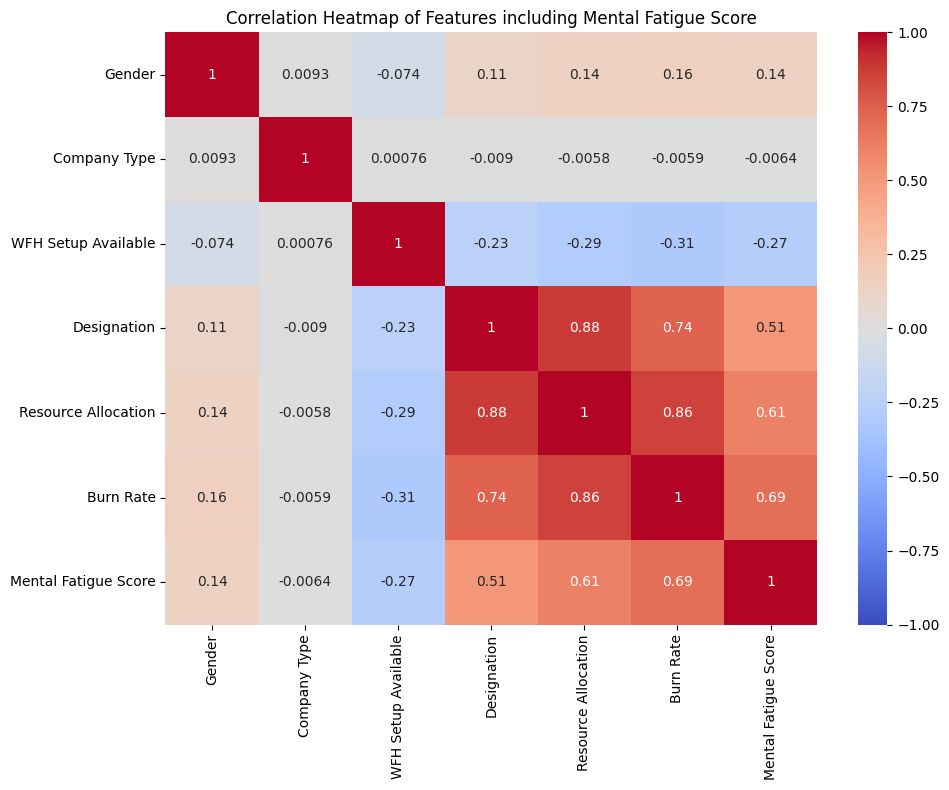

In [10]:
# Creating instance of dataset class
data = Dataset()
data.print()
data.plot_correlation_heatmap()

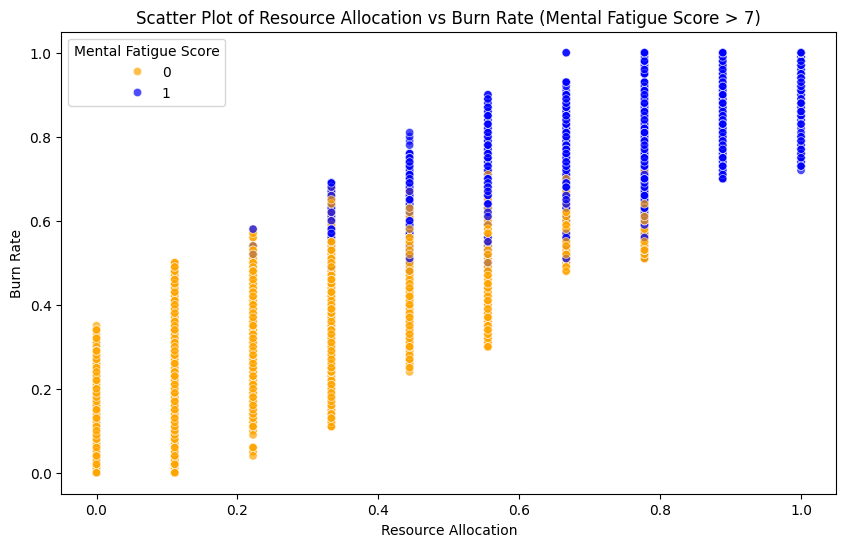

In [11]:
# Scatter plot to check if data is linerally seperable
x_feature = 'Resource Allocation'
y_feature = 'Burn Rate'

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data.X[x_feature], y=data.X[y_feature], hue=data.y, palette={1: 'blue', 0: 'orange'}, alpha=0.7)
plt.title(f'Scatter Plot of {x_feature} vs {y_feature} (Mental Fatigue Score > 7)')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.show()

The Cost / Loss / Error / Objective function, and the optimiser (1 mark).

In [12]:
# Split the data using split of 80/20, using stratify to ensure split maintains the same class distribution in the training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.X, data.y, stratify=data.y, test_size=0.2, random_state=1)

# Setting input dimension
input_dim = X_train.shape[1]

# hyperparameters, epochs to train model, batch size being the number of samples per gradient, fraction for validation set, loss function used for binary classification
EPOCHS = 100
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2
LOSS_FUNCTION = 'binary_crossentropy'

# Defining the model, we used sequential as we take a single input and produce an output
model = Sequential(name='multilayer_perceptron')

# input layer 128 neruons with relu activation, the shape is set to number of features in training set
model.add(Dense(128, activation='relu', input_shape=(input_dim,), name='input'))
model.add(Dropout(0.5, name='dropout'))  #  dropout layer with a dropout rate of 0.5 to prevent overfitting
model.add(Dense(64, activation='relu', name='hidden')) # hidden layer with 64 neurons and Relu activation
model.add(Dense(1, activation='sigmoid', name='output'))  # Sigmoid activation to output probsbilites between 0 and 1

# Compiling the model, we chose adam as optimiser for its use of adaptive LR
# Binary_crossentropy as the loss function, ideal for our predictions as its binary classification
model.compile(optimizer=Adam(learning_rate=0.0001), loss=LOSS_FUNCTION, metrics=['accuracy'])

# summuary of model
model.summary()

# results if the model
results = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "multilayer_perceptron"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (Dense)                        │ (None, 128)                 │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden (Dense)                       │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,217 (36.00 KB)

 Trainable params: 9,217 (36.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6937 - loss: 0.6138 - val_accuracy: 0.8087 - val_loss: 0.4448
Epoch 2/100
744/744 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7995 - loss: 0.4348 - val_accuracy: 0.8467 - val_loss: 0.3515
Epoch 3/100
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8443 - loss: 0.3546 - val_accuracy: 0.8682 - val_loss: 0.3008
Epoch 4/100
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8553 - loss: 0.3153 - val_accuracy: 0.8753 - val_loss: 0.2768
Epoch 5/100
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8657 - loss: 0.2931 - val_accuracy: 0.8780 - val_loss: 0.2633
Epoch 6/100
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8748 - loss: 0.2793 - val_accuracy: 0.8850 - val_loss: 0.2518
Epoch 7/100
744/744 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8685 - loss: 0.2777 - val_accuracy: 0.8864 - val_loss: 0.2449
Epoch 8/100
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8757 - loss: 0.2658 - val_accu

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


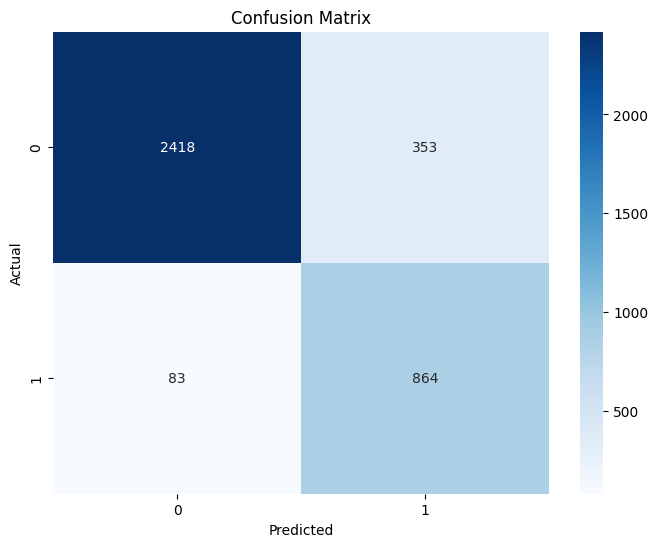

In [13]:
#Confusion matrix
# uses the model to predict probabilites in test dataset and the output.
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.246).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Cross Fold Validation (1 marks).

In [14]:
# Cross Fold Validation
# Split into 5 folds so moel will be trained and tested 5 times
k = 5

# initalise cross validator and shuffle data for random distribution
kf = KFold(n_splits=k, shuffle=True)

# Initalise array of accuracies to print later
accuracies = []

# Loop through each fold
for train_index, test_index in kf.split(data.X, data.y):

    X_train, X_test = data.X.iloc[train_index], data.X.iloc[test_index]
    Y_train, Y_test = data.y.iloc[train_index], data.y.iloc[test_index]

    # Fit the model on the training data
    model.fit(X_train, Y_train, batch_size=128, validation_split=0.2)

    # Predict probabilities on the test data
    y_pred_prob = model.predict(X_test)

    # Convert predicted probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Evaluate the accuracy of the model
    accuracy = accuracy_score(Y_test, y_pred)
    accuracies.append(accuracy)

    # Print accuracy for each fold
    print(f"Accuracy: {accuracy}")

# Print the average accuracy across all folds
print(f"Average accuracy: {np.mean(accuracies)}")


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9048 - loss: 0.1956 - val_accuracy: 0.8951 - val_loss: 0.2086
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.9080150618612157
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9058 - loss: 0.1974 - val_accuracy: 0.8992 - val_loss: 0.2035
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8956428187197418
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9014 - loss: 0.2001 - val_accuracy: 0.8945 - val_loss: 0.2098
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.9050564819795589
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8964 - loss: 0.2011 - val_accuracy: 0.8998 - val_loss: 0.2062
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9018289402904788
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9042 - loss: 0.1989 - val_accuracy: 0.8894 - val_loss: 0.2166
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.898870360408822
Average accuracy: 0.9018827326519634


Results – accuracy and/or precision and/or recall: with plots included (2 mark).


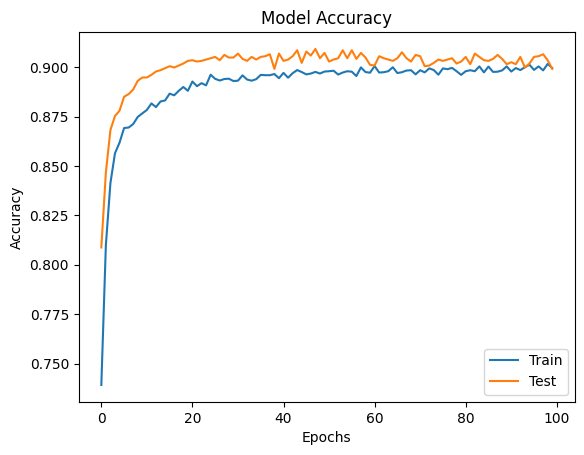

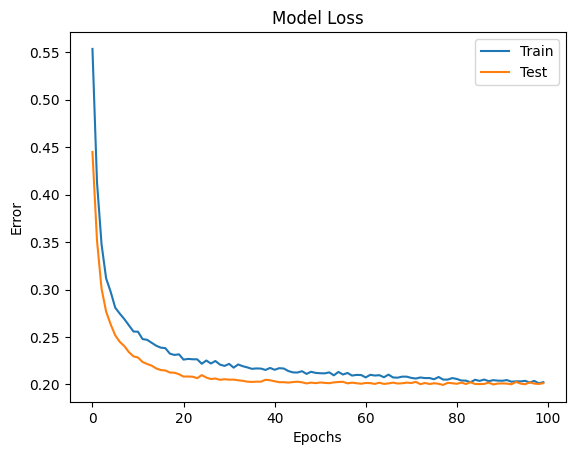

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6244 - loss: 2.2285


In [15]:
# Results: Accuracy and loss graphs
# Extract training accuracy and loss values
training_accuracy = results.history['accuracy']
training_loss = results.history['loss']

# Extract figures for accuracy and loss values
validation_accuracy = results.history['val_accuracy']
validation_loss = results.history['val_loss']

# plot accuracy
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Test"], loc="lower right")
plt.show()

# Plot loss
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Model Loss')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test)

Impact of varying a hyperparameter(s) (2 marks).



In [16]:
# Set Epochs to 1- and plot all again
EPOCHS = 10

results = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7052 - loss: 1.0728 - val_accuracy: 0.7422 - val_loss: 0.6376
Epoch 2/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7490 - loss: 0.6145 - val_accuracy: 0.7435 - val_loss: 0.6008
Epoch 3/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7418 - loss: 0.5997 - val_accuracy: 0.7435 - val_loss: 0.5875
Epoch 4/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7496 - loss: 0.5751 - val_accuracy: 0.7435 - val_loss: 0.5810
Epoch 5/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7538 - loss: 0.5673 - val_accuracy: 0.7439 - val_loss: 0.5773
Epoch 6/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7471 - loss: 0.5697 - val_accuracy: 0.7439 - val_loss: 0.5753
Epoch 7/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7473 - loss: 0.5699 - val_accuracy: 0.7439 - val_loss: 0.5738
Epoch 8/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7471 - loss: 0.5676 - val_accuracy: 0.

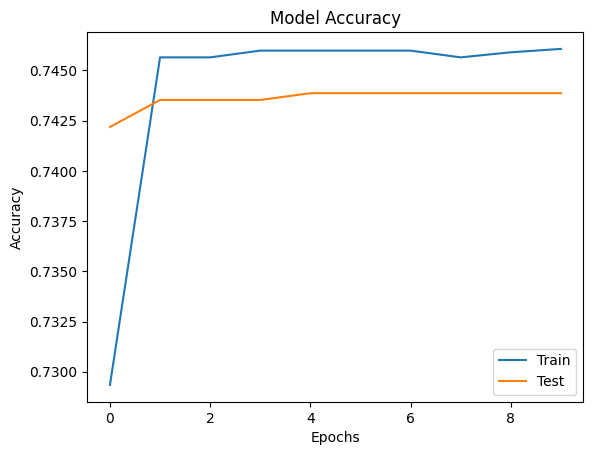

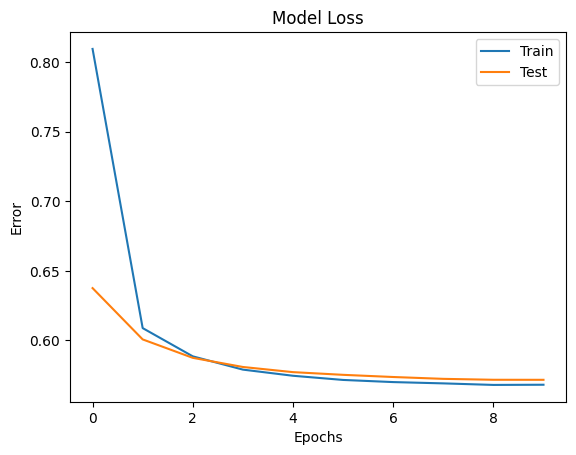

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7429 - loss: 0.5715


In [17]:
# plot the impact of changing epochs accuracy and loss
training_accuracy = results.history['accuracy']
training_loss = results.history['loss']
validation_accuracy = results.history['val_accuracy']
validation_loss = results.history['val_loss']

# accuracy
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Test"], loc="lower right")
plt.show()

#  loss
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Model Loss')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test)

In [18]:
# With an Epoch set at 10
EPOCHS = 100
VALIDATION_SPLIT = 0.5

results = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7409 - loss: 0.5730 - val_accuracy: 0.7501 - val_loss: 0.5626
Epoch 2/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7281 - loss: 0.5868 - val_accuracy: 0.7501 - val_loss: 0.5627
Epoch 3/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7486 - loss: 0.5644 - val_accuracy: 0.7501 - val_loss: 0.5625
Epoch 4/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7423 - loss: 0.5701 - val_accuracy: 0.7501 - val_loss: 0.5624
Epoch 5/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7390 - loss: 0.5743 - val_accuracy: 0.7501 - val_loss: 0.5623
Epoch 6/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7333 - loss: 0.5813 - val_accuracy: 0.7501 - val_loss: 0.5623
Epoch 7/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7451 - loss: 0.5673 - val_accuracy: 0.7501 - val_loss: 0.5625
Epoch 8/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7304 - loss: 0.5814 - val_accu

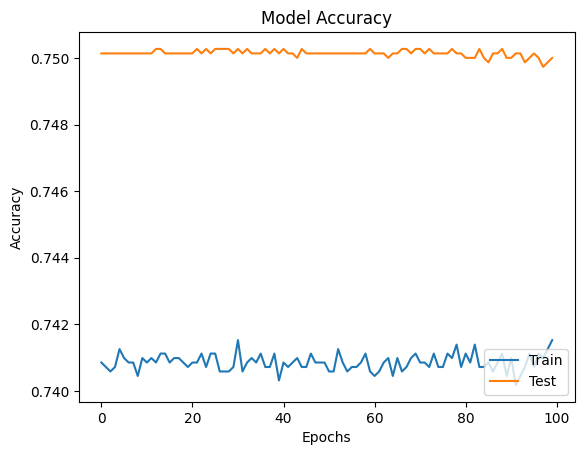

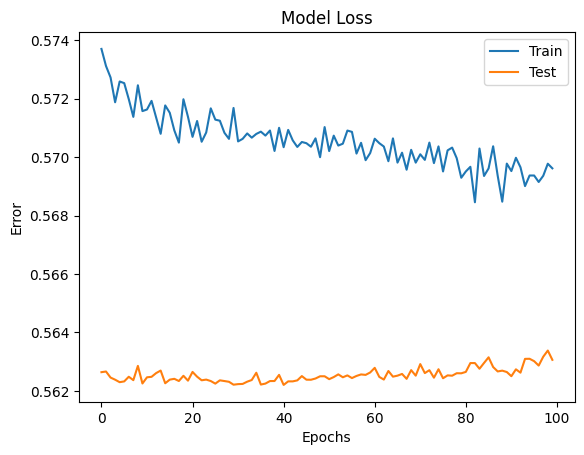

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7426 - loss: 0.5721


In [19]:
# plot the impact of changing validation split accuracy and loss
training_accuracy = results.history['accuracy']
training_loss = results.history['loss']


validation_accuracy = results.history['val_accuracy']
validation_loss = results.history['val_loss']

# accuracy
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Test"], loc="lower right")
plt.show()

# loss
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Model Loss')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test)